In this notebook, I build 3 classification models to predict the job title given a job description. The 3 classification models I used are the Naive bayes classifier, Logistic regression classifier and Keras with LSTM layers.

#### Import libraries

#### Cleaner function

In [2]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import string

# Stop word list to filter noise in bag of words
stop_list = stopwords.words('english')

# all letters except for r
letters = string.ascii_lowercase[:17] + string.ascii_lowercase[18:]
letters_list = [letters[l] for l in range(len(letters))]

WNL = WordNetLemmatizer()

punct_list = [punctuation[p] for p in range(len(punctuation))]
add_stop_words = ['class', 'div', 'description__text', 'ul', 
                  'li', 'br', 'ul', 'job', 'description', 'rich', 
                  'strong', 'to', 'apply', 'visit', 'the', 'and',
                  'make', 'at', 'you', 'we', 'our', 'would', 'via',
                  'pte', 'ltd', 'us', 'please', 'lt', 'weight', 'gt',
                  'span', 'em']

stop_list += punct_list + add_stop_words + letters_list

def cleaner(x):
    output = []
    x = re.sub(r'<[\sa-zA-Z0-9=\-_/"]+>', ' ', x)
    for w in x.split():
        curr_word = WNL.lemmatize(w)
        curr_word = curr_word.lower()
        curr_word = re.sub(r'[^\w\s]', '', str(curr_word))
        if curr_word not in stop_list:
            output.append(curr_word)
    return ' '.join(output)

# stop_list

#### Combine all scraped_data csv to a single df

In [3]:
# Combine all csv files to one master csv file
datafolder = './scraped_data/'
allfiles = [f for f in listdir(datafolder) if isfile(join(datafolder, f))]

d = {'Job Title': [], 'Company Name': [], 'Country': [], 'When Posted': [], 'No. of Applicants': [], 'Hyperlink': [], 'Job Description': [], 'Job Search': []}
master = pd.DataFrame(data = d)

for f in allfiles:
    print('loading {} ...'.format(f))
    df = pd.read_csv(datafolder + f)
    
    # Remove error rows
    df = df.loc[df['Job Title'] != 'error']
    
    # Remove duplicates
    duplicate_rows = df.duplicated(subset = ['Job Title', 'Company Name'], keep = 'first') # returns True for all 2nd duplicated rows
    duplicate_rows_list = duplicate_rows.tolist()  
    df = df[~duplicate_rows]
    
    # Create new column job search
    df['Job Search'] = f.split('_')[1].split('.')[0]
    
    # Clean job description
    df['Job Description'] =  df['Job Description'].replace(np.nan, '')
    df['Job Description'] = df.apply(lambda x: cleaner(x['Job Description']), axis = 1)
        
    master = master.append(df, ignore_index = True)

loading linkedin_business analyst.csv ...
loading linkedin_cybersecurity.csv ...
loading linkedin_data science.csv ...
loading linkedin_human resource.csv ...
loading linkedin_operations.csv ...
loading linkedin_software developer.csv ...


#### Create integer label column for classification later

In [4]:
def job_labeler(text):
    label_id = 1
    label_dict = {}
    for i in text:
        i = i.split('_')[1].split('.')[0]
        label_dict[i] = label_id
        label_id += 1
    return label_dict

job_labels = job_labeler(allfiles)

master['label'] = master['Job Search'].apply(lambda x: job_labels[x])

In [5]:
master.head(3)

,Job Title,Company Name,Country,When Posted,No. of Applicants,Hyperlink,Job Description,Job Search,label
0,Apple Support Business Analyst,Apple,Singapore| Singapore,4 weeks ago,55 applicants,https://sg.linkedin.com/jobs/view/apple-suppor...,summary imagine could apple great idea way bec...,business analyst,1
1,Business Analyst,One North,Singapore| Singapore,4 days ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/business-ana...,amp requirements role indepth understanding bu...,business analyst,1
2,IKEA Jurong - Business Analyst,IKEA,Singapore| Singapore,6 days ago,Over 200 applicants,https://sg.linkedin.com/jobs/view/ikea-jurong-...,company ikea vision create better everyday lif...,business analyst,1


In [6]:
master.tail(3)

,Job Title,Company Name,Country,When Posted,No. of Applicants,Hyperlink,Job Description,Job Search,label
5489,Software Engineer (DevOps),GARUDA ROBOTICS PTE. LTD.,Singapore| Singapore,2 weeks ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/software-eng...,devops software engineer manage entire lifecyc...,software developer,6
5490,Lead Software Engineer / Senior Software Engin...,Golden Bridge Drive SG,Singapore| Singapore,4 weeks ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/lead-softwar...,golden bridge drive digital product company sp...,software developer,6
5491,Software Engineer,Secure Parking Singapore Pte Ltd secureparking...,Singapore| Singapore,2 weeks ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/software-eng...,software developer lead support various task a...,software developer,6


#### Split to train and test set

In [7]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(master['Job Description'], master['label'], test_size = 0.2, random_state = 123, stratify = master['Job Search'])

# For deep learning model, convert output labels to numpy before fitting to model
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

In [8]:
# Check if test and train sets are stratified
print('\033[1m' + 'Train set distribution:' + '\033[0m')
print(pd.value_counts(y_train))
print('\033[1m' + '\nTest set distribution:' + '\033[0m')
print(pd.value_counts(y_test))

Train set distribution:
5    755
2    739
4    733
3    731
1    730
6    705
Name: label, dtype: int64

Test set distribution:
5    189
2    185
4    184
3    183
1    182
6    176
Name: label, dtype: int64


# NB Classifier
Transform training data into a tf-idf vectorizer and fit it into a Multinomial Naive Bayes classifier model.

In [9]:
# Fit and transform the training data
tf = TfidfVectorizer()
x_train_tfidf = tf.fit_transform(x_train)

In [10]:
# Fit the model
NB_model = MultinomialNB()

# Fit to training data
NB_model.fit(x_train_tfidf, y_train)

# Vectorize test data using same tf object
x_test_tfidf = tf.transform(x_test)

In [11]:
nb_predicted_labels = NB_model.predict(x_test_tfidf)

In [12]:
print(classification_report(y_test, nb_predicted_labels))

              precision    recall  f1-score   support

           1       0.70      0.77      0.74       182
           2       0.93      0.83      0.87       185
           3       0.75      0.75      0.75       183
           4       0.82      0.90      0.86       184
           5       0.74      0.72      0.73       189
           6       0.89      0.84      0.86       176

    accuracy                           0.80      1099
   macro avg       0.81      0.80      0.80      1099
weighted avg       0.81      0.80      0.80      1099



# LR Classifier
Fit tf-idf vectorizer into a Logistic Regression classifier model.

In [13]:
LR_model = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 123)

In [14]:
LR_model.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=123, solver='liblinear')

In [15]:
lr_predicted_labels = LR_model.predict(x_test_tfidf)

In [16]:
print(classification_report(y_test, lr_predicted_labels))

              precision    recall  f1-score   support

           1       0.83      0.73      0.78       182
           2       0.97      0.80      0.88       185
           3       0.78      0.79      0.79       183
           4       0.91      0.89      0.90       184
           5       0.72      0.87      0.78       189
           6       0.85      0.93      0.89       176

    accuracy                           0.83      1099
   macro avg       0.84      0.83      0.83      1099
weighted avg       0.84      0.83      0.83      1099



# Deep Learning - LSTM

Histogram of length of job descriptions. Set max words to 350 for dense vectors.

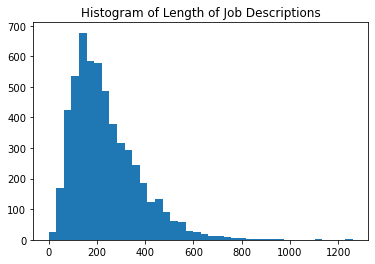

In [17]:
def find_length(x):
    return(len(x.split()))

master['Length of Job Descriptions'] = master.apply(lambda x: find_length(x['Job Description']), axis = 1)

# Max number of words in a sequence
max_length = 350

plt.hist(master['Length of Job Descriptions'], bins = 40)
plt.title('Histogram of Length of Job Descriptions')
plt.show()

In [18]:
# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text = master['Job Description']
counter = counter_word(text)
num_words = len(counter)

In [19]:
# Create BOW
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [20]:
# Create train and test sequences
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [21]:
# Clipping and padding
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen = max_length, padding = 'pre', truncating = 'pre')

test_padded = pad_sequences(
    test_sequences, maxlen = max_length, padding = 'pre', truncating = 'pre')

print('Shape of train {}'.format(str(train_padded.shape)))
print('Shape of test {}'.format(str(test_padded.shape)))

Shape of train (4393, 350)
Shape of test (1099, 350)


In [24]:
# Check inverse
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode(train_sequences[123])

'talented senior software engineer passionate creating new technology developing innovative solutions join next products amp platform pampp part onechat team create next generation collaboration platform ai powered secure chat amp video conferencing solution enterprises pampp leverage latest technology create groundbreaking product help accelerate client digital transformation agenda deep expertise robotics iot computer vision audio intelligence speech analytics much join role develop support internal product onechat serf communication platform ncs staff customers responsibilities designing developing highvolume lowlatency application missioncritical system delivering highavailability performance contribute phase development lifecycle write well designed testable efficient code ensure design compliance specification prepare produce release software component support continuous improvement investigating alternative technology presenting architectural review ideal candidate possess bsms 

In [29]:
# Build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Embedding(num_words, 32, input_length = max_length))
model.add(LSTM(100, dropout = 0.1, return_sequences = True))
model.add(LSTM(50, dropout = 0.2))
model.add(Dense(10, activation = 'softmax'))

optimizer = Adam()
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 32)           991264    
_________________________________________________________________
lstm_2 (LSTM)                (None, 350, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 1,075,174
Trainable params: 1,075,174
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(
    train_padded, y_train_array, epochs = 120,
    validation_split = 0.1)

Epoch 1/120
124/124 [==============================] - 28s 229ms/step - loss: 0.0593 - accuracy: 0.9653 - val_loss: 1.3026 - val_accuracy: 0.7455
Epoch 2/120
124/124 [==============================] - 28s 228ms/step - loss: 0.0582 - accuracy: 0.9653 - val_loss: 1.4152 - val_accuracy: 0.7386
Epoch 3/120
124/124 [==============================] - 30s 240ms/step - loss: 0.0648 - accuracy: 0.9646 - val_loss: 1.3378 - val_accuracy: 0.7318
Epoch 4/120
124/124 [==============================] - 29s 238ms/step - loss: 0.0638 - accuracy: 0.9666 - val_loss: 1.3655 - val_accuracy: 0.7341
Epoch 5/120
124/124 [==============================] - 30s 240ms/step - loss: 0.0715 - accuracy: 0.9633 - val_loss: 1.4818 - val_accuracy: 0.7045
Epoch 6/120
124/124 [==============================] - 30s 241ms/step - loss: 0.0890 - accuracy: 0.9598 - val_loss: 1.3876 - val_accuracy: 0.7364
Epoch 7/120
124/124 [==============================] - 29s 232ms/step - loss: 0.0759 - accuracy: 0.9633 - val_loss: 1.4095 -

Epoch 57/120
124/124 [==============================] - 27s 220ms/step - loss: 0.0516 - accuracy: 0.9689 - val_loss: 1.5285 - val_accuracy: 0.7364
Epoch 58/120
124/124 [==============================] - 27s 218ms/step - loss: 0.0494 - accuracy: 0.9696 - val_loss: 1.5110 - val_accuracy: 0.7409
Epoch 59/120
124/124 [==============================] - 27s 219ms/step - loss: 0.0467 - accuracy: 0.9724 - val_loss: 1.4976 - val_accuracy: 0.7500
Epoch 60/120
124/124 [==============================] - 27s 219ms/step - loss: 0.0478 - accuracy: 0.9679 - val_loss: 1.5170 - val_accuracy: 0.7477
Epoch 61/120
124/124 [==============================] - 27s 219ms/step - loss: 0.0479 - accuracy: 0.9684 - val_loss: 1.4920 - val_accuracy: 0.7523
Epoch 62/120
124/124 [==============================] - 27s 222ms/step - loss: 0.0500 - accuracy: 0.9681 - val_loss: 1.5751 - val_accuracy: 0.7409
Epoch 63/120
124/124 [==============================] - 27s 220ms/step - loss: 0.0490 - accuracy: 0.9691 - val_loss: 1

124/124 [==============================] - 28s 222ms/step - loss: 0.0448 - accuracy: 0.9696 - val_loss: 1.4339 - val_accuracy: 0.7500
Epoch 113/120
124/124 [==============================] - 27s 221ms/step - loss: 0.0435 - accuracy: 0.9686 - val_loss: 1.4226 - val_accuracy: 0.7523
Epoch 114/120
124/124 [==============================] - 27s 221ms/step - loss: 0.0434 - accuracy: 0.9684 - val_loss: 1.4529 - val_accuracy: 0.7591
Epoch 115/120
124/124 [==============================] - 28s 222ms/step - loss: 0.0421 - accuracy: 0.9679 - val_loss: 1.4699 - val_accuracy: 0.7614
Epoch 116/120
124/124 [==============================] - 28s 223ms/step - loss: 0.0422 - accuracy: 0.9686 - val_loss: 1.4473 - val_accuracy: 0.7705
Epoch 117/120
124/124 [==============================] - 28s 223ms/step - loss: 0.0424 - accuracy: 0.9689 - val_loss: 1.4707 - val_accuracy: 0.7636
Epoch 118/120
124/124 [==============================] - 28s 223ms/step - loss: 0.0417 - accuracy: 0.9691 - val_loss: 1.4653 -

In [32]:
# Check accuracy on test data
test_loss, test_acc = model.evaluate(test_padded, y_test_array, verbose = 0)
print('Test accuracy: ', test_acc)

Test accuracy:  0.7415832281112671


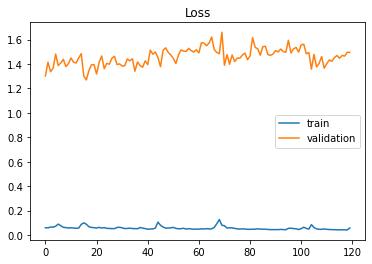

In [33]:
from matplotlib import pyplot
# plot loss during training
pyplot.plot()
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'validation')
pyplot.legend()
pyplot.show()

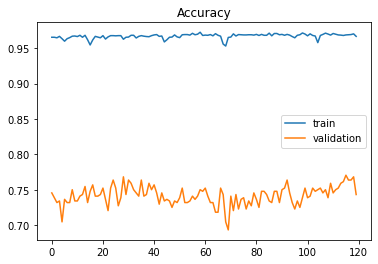

In [34]:
# plot accuracy during training
pyplot.plot()
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label = 'train')
pyplot.plot(history.history['val_accuracy'], label = 'validation')
pyplot.legend()
pyplot.show()